In [24]:
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import scipy.signal as signal_proc
from scipy.signal import butter, filtfilt, medfilt, resample_poly, hilbert
import pandas as pd
from scipy.signal import find_peaks

def compute_fft_with_hann(signal, sampling_freq):
    """
    Compute FFT with Hann window for power spectral density estimation
    
    Parameters:
    - signal: input signal
    - sampling_freq: sampling frequency in Hz
    
    Returns:
    - freqs: frequency array
    - psd: power spectral density
    """
    # Apply Hann window
    windowed_signal = signal * np.hanning(len(signal))
    
    # Compute FFT
    fft_result = np.fft.fft(windowed_signal)
    
    # Calculate frequencies
    freqs = np.fft.fftfreq(len(signal), 1/sampling_freq)
    
    # Take only positive frequencies (one-sided spectrum)
    positive_freq_idx = freqs >= 0
    freqs = freqs[positive_freq_idx]
    fft_result = fft_result[positive_freq_idx]
    
    # Calculate power spectral density
    # Scale by 2 to account for negative frequencies (except DC and Nyquist)
    psd = np.abs(fft_result)**2 / (sampling_freq * len(signal))
    psd[1:-1] *= 2  # Scale all frequencies except DC and Nyquist
    
    # Correct for window power
    window_power = np.mean(np.hanning(len(signal))**2)
    psd /= window_power
    
    return freqs, psd

# Add project path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from ml_toolbox.data_loader import DataLoader, WindowConfig, WindowExtractor

# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '10hz'
sensor_type = 'current'
load = 'no_load'

if sensor_type == 'current':
    sampling_rate = 10000 
    nperseg = 2048 
else:
    sampling_rate = 26041
    nperseg = 1024
    
xlim = sampling_rate / 2
# Load one sample for demo
healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

# Load faulty data for comparison
faulty_data, faulty_metadata = data_loader.load_batch(
    condition='faulty_bearing', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = 4096 #healthy[0].shape[0] 
n_faulty = 4096 #faulty_data[0].shape[0]

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

faulty_step_size = int(faulty_data[0].shape[0] * (1 - overlap_ratio))
faulty_window_config = WindowConfig(
    window_size=n_faulty,
    step_size=faulty_step_size,
    overlap_ratio=overlap_ratio
)

faulty_extractor = WindowExtractor(faulty_window_config)
faulty_windows, faulty_win_metadata = faulty_extractor.extract_windows(faulty_data[0], faulty_metadata[0])

print(f"Loaded faulty signal: {faulty_data[0].shape}")
print(f"Created {len(faulty_windows)} faulty windows")

print(f"Loaded healthy signal: {healthy[0].shape}")
print(f"Created {len(healthy_windows)} healthy windows")

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

f_w = faulty_windows[0]
f_ch1 = f_w[:, 0]
f_ch2 = f_w[:, 1]

h_ch1_orig = h_ch1.copy()
f_ch1_orig = f_ch1.copy()

h_ch1_lpf = h_ch1.copy()
f_ch1_lpf = f_ch1.copy()

# Define filter parameters
nyquist = sampling_rate / 2

# Carrier freqs: 1450-1550 Hz; 3050-3150 Hz (PWM harmonics?)
low_freq_1 = 3050.0
high_freq_1 = 3150.0
b1, a1 = butter(4, [low_freq_1/nyquist, high_freq_1/nyquist], btype='band', analog=False)

# Apply band-pass filters to healthy signals
h_ch1 = filtfilt(b1, a1, h_ch1)

# Apply band-pass filters to faulty signals
f_ch1 = filtfilt(b1, a1, f_ch1)

env_h = np.abs(hilbert(h_ch1))
env_f = np.abs(hilbert(f_ch1))

# # Apply Butter
cutoff = 200.0  # Hz, just above 200 Hz
xlim = cutoff + 50.0  # for plotting
b, a = butter(4, cutoff / nyquist, btype='low', analog=False)
h_ch1 = filtfilt(b, a, env_h)
f_ch1 = filtfilt(b, a, env_f)

# # decimate by 5 safely (resample_poly does anti-alias filtering too)
decim = 5
h_ch1 = resample_poly(h_ch1, up=1, down=decim)
f_ch1 = resample_poly(f_ch1, up=1, down=decim)
fs_env = sampling_rate / decim  # 2000 Hz

# Just filter channels with low-pass for comparison
h_ch1_lpf = filtfilt(b, a, h_ch1_lpf)
f_ch1_lpf = filtfilt(b, a, f_ch1_lpf)

# Calculate PSD 
# Calculate PSD using Welch method (keep commented FFT for reference)
# freqs_h_ch1, psd_h_ch1 = compute_fft_with_hann(h_ch1, sampling_freq=sampling_rate)
freqs_h_ch1, psd_h_ch1 = signal_proc.welch(h_ch1, fs=fs_env, nperseg=nperseg)
# freqs_h_ch2, psd_h_ch2 = compute_fft_with_hann(h_ch2, sampling_freq=sampling_rate)
freqs_h_ch2, psd_h_ch2 = signal_proc.welch(h_ch2, fs=fs_env, nperseg=nperseg)
# freqs_f_ch1, psd_f_ch1 = compute_fft_with_hann(f_ch1, sampling_freq=sampling_rate)
freqs_f_ch1, psd_f_ch1 = signal_proc.welch(f_ch1, fs=fs_env, nperseg=nperseg)
# freqs_f_ch2, psd_f_ch2 = compute_fft_with_hann(f_ch2, sampling_freq=sampling_rate)
freqs_f_ch2, psd_f_ch2 = signal_proc.welch(f_ch2, fs=fs_env, nperseg=nperseg)

freqs_h_ch1_lpf, psd_h_ch1_lpf = signal_proc.welch(h_ch1_lpf, fs=fs_env, nperseg=nperseg)
freqs_f_ch1_lpf, psd_f_ch1_lpf = signal_proc.welch(f_ch1_lpf, fs=fs_env, nperseg=nperseg)

freqs_h_ch1_orig, psd_h_ch1_orig = signal_proc.welch(h_ch1_orig, fs=sampling_rate, nperseg=1024)
freqs_f_ch1_orig, psd_f_ch1_orig = signal_proc.welch(f_ch1_orig, fs=sampling_rate, nperseg=1024)

# Normalize PSD for peak tracking
psd_h_ch1 /= np.max(psd_h_ch1)
psd_h_ch2 /= np.max(psd_h_ch2)
psd_f_ch1 /= np.max(psd_f_ch1)
psd_f_ch2 /= np.max(psd_f_ch2)

psd_h_ch1_lpf /= np.max(psd_h_ch1_lpf)
psd_f_ch1_lpf /= np.max(psd_f_ch1_lpf)

psd_h_ch1_orig /= np.max(psd_h_ch1_orig)
psd_f_ch1_orig /= np.max(psd_f_ch1_orig)

#find peaks
# Calculate median only up to cutoff frequency for more reasonable noise floor estimation
cutcut = 130
cutoff_idx_h = np.where(freqs_h_ch1 <= cutcut)[0][-1] if len(np.where(freqs_h_ch1 <= cutcut)[0]) > 0 else len(freqs_h_ch1)//2
cutoff_idx_f = np.where(freqs_f_ch1 <= cutcut)[0][-1] if len(np.where(freqs_f_ch1 <= cutcut)[0]) > 0 else len(freqs_f_ch1)//2

noise_floor_h_ch1 = np.median(psd_h_ch1[:cutoff_idx_h])
noise_floor_h_ch2 = np.median(psd_h_ch2[:cutoff_idx_h]) if 'psd_h_ch2' in locals() else 0
noise_floor_f_ch1 = np.median(psd_f_ch1[:cutoff_idx_f])
noise_floor_f_ch2 = np.median(psd_f_ch2[:cutoff_idx_f]) if 'psd_f_ch2' in locals() else 0

peaks_h_ch1, _ = find_peaks(psd_h_ch1, 
                           height=noise_floor_h_ch1*2,  
                           prominence=noise_floor_h_ch1*2,  
                           distance=2)
peaks_h_ch2, _ = find_peaks(psd_h_ch2, 
                           height=noise_floor_h_ch2*2,  
                           prominence=noise_floor_h_ch2*2,  
                           distance=2) if 'psd_h_ch2' in locals() else ([], {})
peaks_f_ch1, _ = find_peaks(psd_f_ch1, 
                           height=noise_floor_f_ch1*2, 
                           prominence=noise_floor_f_ch1*2,  
                           distance=2)
peaks_f_ch2, _ = find_peaks(psd_f_ch2, 
                           height=noise_floor_f_ch2*2,  
                           prominence=noise_floor_f_ch2*2,  
                           distance=2) if 'psd_f_ch2' in locals() else ([], {})


INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


Loaded faulty signal: (194449, 2)
Created 93 faulty windows
Loaded healthy signal: (191650, 2)
Created 92 healthy windows


C:\Users\gkb\AppData\Local\Temp\ipykernel_14676\3670672384.py:170: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 820, using nperseg = 820
  freqs_h_ch1, psd_h_ch1 = signal_proc.welch(h_ch1, fs=fs_env, nperseg=nperseg)
C:\Users\gkb\AppData\Local\Temp\ipykernel_14676\3670672384.py:174: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 820, using nperseg = 820
  freqs_f_ch1, psd_f_ch1 = signal_proc.welch(f_ch1, fs=fs_env, nperseg=nperseg)


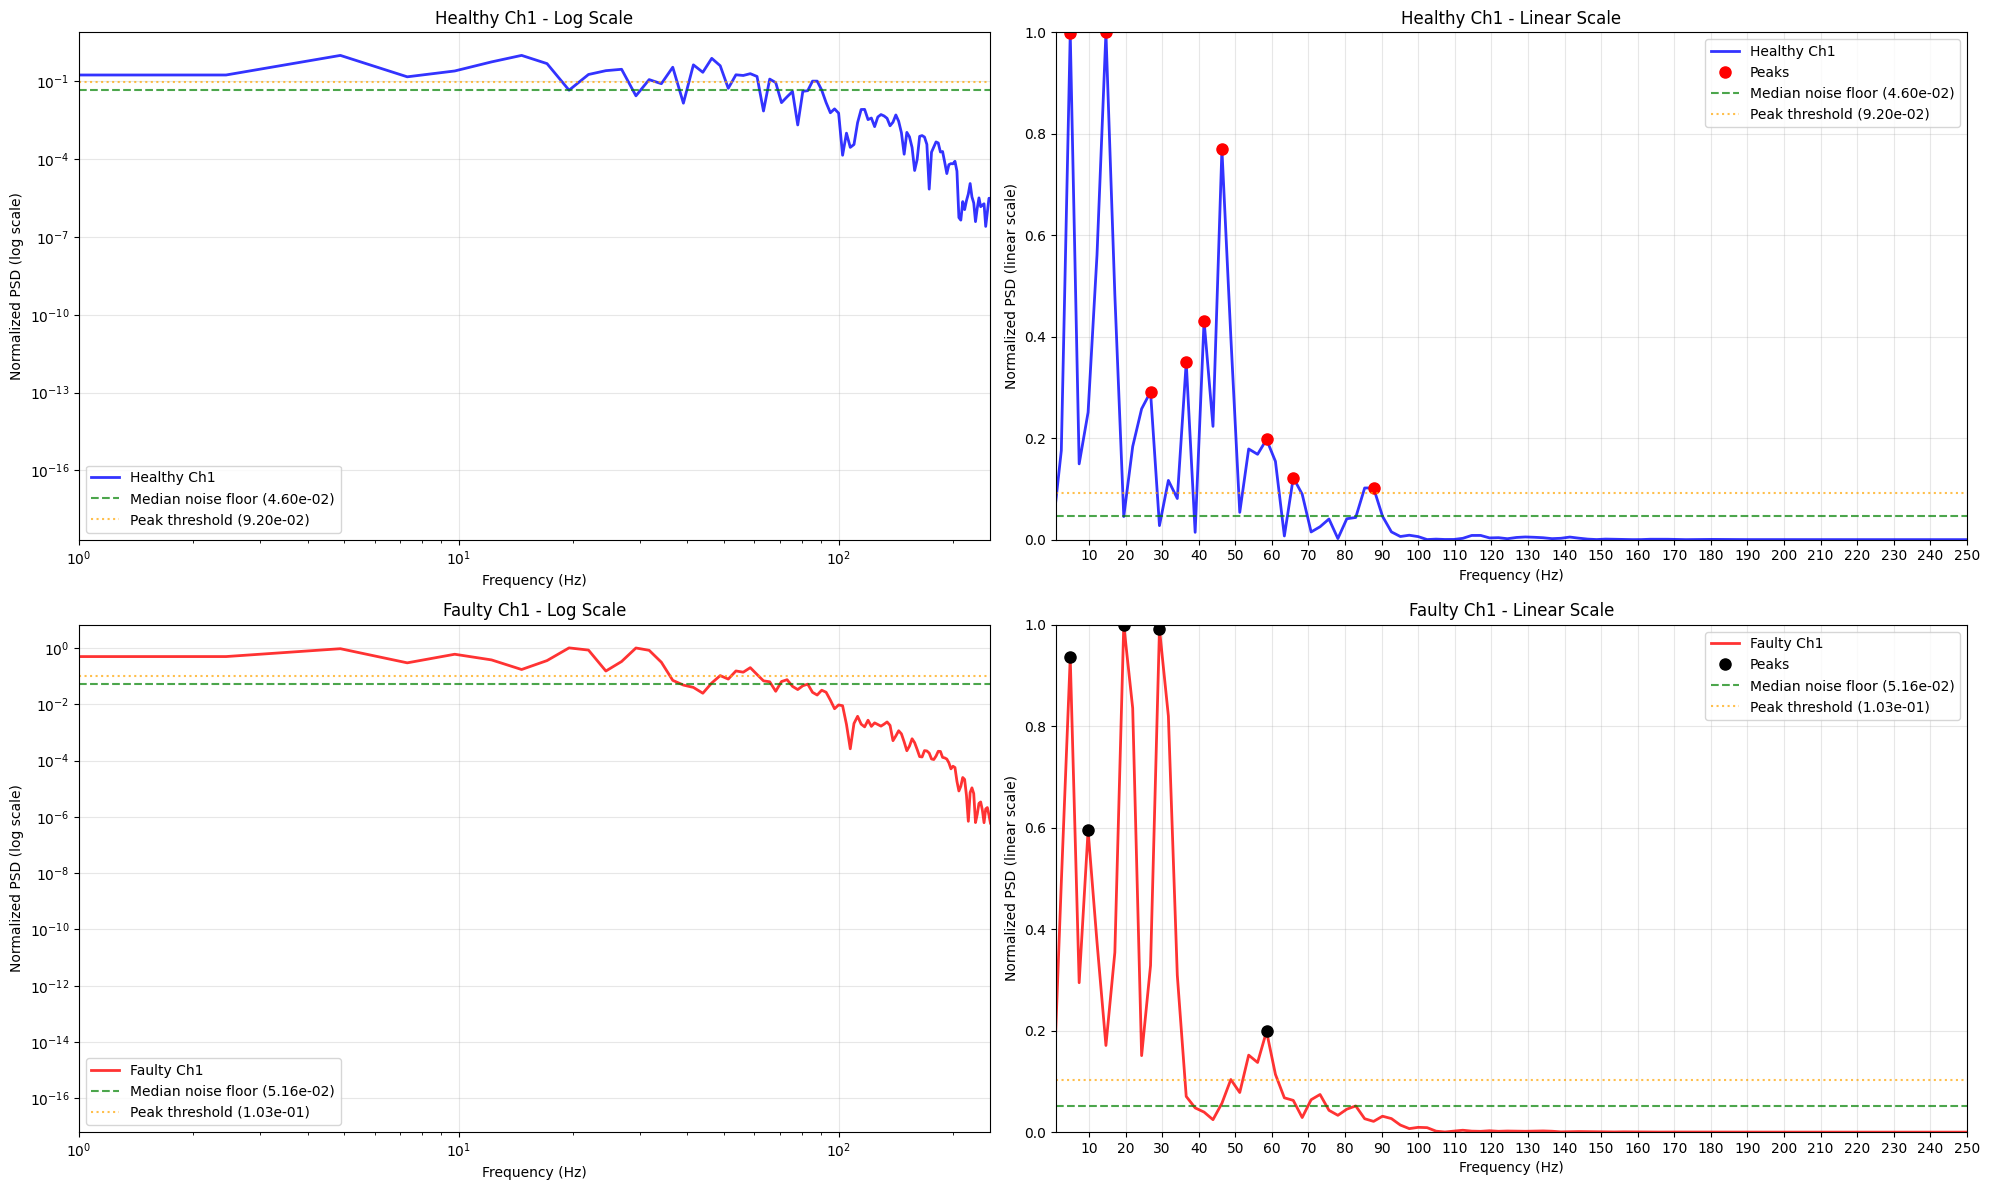

Number of peaks - Healthy: 9, Faulty: 5

Healthy Ch1 peak frequencies and amplitudes:
  Peak 1: 4.88 Hz, Amplitude: 9.98e-01
  Peak 2: 14.63 Hz, Amplitude: 1.00e+00
  Peak 3: 26.83 Hz, Amplitude: 2.91e-01
  Peak 4: 36.59 Hz, Amplitude: 3.50e-01
  Peak 5: 41.46 Hz, Amplitude: 4.32e-01
  Peak 6: 46.34 Hz, Amplitude: 7.69e-01
  Peak 7: 58.54 Hz, Amplitude: 1.97e-01
  Peak 8: 65.85 Hz, Amplitude: 1.22e-01
  Peak 9: 87.80 Hz, Amplitude: 1.02e-01

Faulty Ch1 peak frequencies and amplitudes:
  Peak 1: 4.88 Hz, Amplitude: 9.36e-01
  Peak 2: 9.76 Hz, Amplitude: 5.95e-01
  Peak 3: 19.51 Hz, Amplitude: 1.00e+00
  Peak 4: 29.27 Hz, Amplitude: 9.92e-01
  Peak 5: 58.54 Hz, Amplitude: 1.99e-01

Peak amplitude comparison:
  Healthy - Max amplitude: 1.00e+00
  Healthy - Mean amplitude: 4.74e-01
  Faulty - Max amplitude: 1.00e+00
  Faulty - Mean amplitude: 7.44e-01
  Faulty/Healthy amplitude ratio: 1.57
Faulty condition shows significantly higher peak amplitudes


In [25]:
# Plot individual PSDs with peaks and median lines - both log and linear scales
top_y = 1
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Left column: Log-log plots
# Channel 1 - Healthy with peaks (log scale)
axes[0, 0].loglog(freqs_h_ch1, psd_h_ch1, 'b-', alpha=0.8, label='Healthy Ch1', linewidth=2)
# Add median noise floor line
axes[0, 0].axhline(y=noise_floor_h_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_h_ch1:.2e})')
# Add threshold line (90th percentile)
axes[0, 0].axhline(y=noise_floor_h_ch1*2, color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({noise_floor_h_ch1*2:.2e})')
axes[0, 0].set_xlim(1, xlim)
#axes[0, 0].set_ylim(bottom=1e-6, top=top_y)  # Limit y-axis to handle large DC component
#axes[0, 0].set_xticks(np.arange(10, xlim+1, 10))
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Normalized PSD (log scale)')
axes[0, 0].set_title('Healthy Ch1 - Log Scale')
axes[0, 0].legend()

# Channel 1 - Faulty with peaks (log scale)
axes[1, 0].loglog(freqs_f_ch1, psd_f_ch1, 'r-', alpha=0.8, label='Faulty Ch1', linewidth=2)
# Add median noise floor line
axes[1, 0].axhline(y=noise_floor_f_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_f_ch1:.2e})')
# Add threshold line (90th percentile)
axes[1, 0].axhline(y=noise_floor_f_ch1*2, color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({noise_floor_f_ch1*2:.2e})')
axes[1, 0].set_xlim(1, xlim)
#axes[1, 0].set_ylim(bottom=1e-6, top=top_y)  # Limit y-axis to handle large DC component
#axes[1, 0].set_xticks(np.arange(10, xlim+1, 10))
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Normalized PSD (log scale)')
axes[1, 0].set_title('Faulty Ch1 - Log Scale')
axes[1, 0].legend()

# Right column: Linear plots
# Channel 1 - Healthy with peaks (linear scale)
axes[0, 1].plot(freqs_h_ch1, psd_h_ch1, 'b-', alpha=0.8, label='Healthy Ch1', linewidth=2)
# Mark peaks
axes[0, 1].plot(freqs_h_ch1[peaks_h_ch1], psd_h_ch1[peaks_h_ch1], 'ro', markersize=8, label='Peaks')
# Add median noise floor line
axes[0, 1].axhline(y=noise_floor_h_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_h_ch1:.2e})')
# Add threshold line (90th percentile)
axes[0, 1].axhline(y=noise_floor_h_ch1*2, color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({noise_floor_h_ch1*2:.2e})')
axes[0, 1].set_xlim(1, xlim)
axes[0, 1].set_ylim(bottom=0, top=top_y)  # Limit y-axis to handle large DC component
# Add more x-axis ticks
axes[0, 1].set_xticks(np.arange(10, xlim+1, 10))
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Normalized PSD (linear scale)')
axes[0, 1].set_title('Healthy Ch1 - Linear Scale')
axes[0, 1].legend()

# Channel 1 - Faulty with peaks (linear scale)
axes[1, 1].plot(freqs_f_ch1, psd_f_ch1, 'r-', alpha=0.8, label='Faulty Ch1', linewidth=2)
# Mark peaks
axes[1, 1].plot(freqs_f_ch1[peaks_f_ch1], psd_f_ch1[peaks_f_ch1], 'ko', markersize=8, label='Peaks')
# Add median noise floor line
axes[1, 1].axhline(y=noise_floor_f_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_f_ch1:.2e})')
# Add threshold line (90th percentile)
axes[1, 1].axhline(y=noise_floor_f_ch1*2, color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({noise_floor_f_ch1*2:.2e})')
axes[1, 1].set_xlim(1, xlim)
axes[1, 1].set_ylim(bottom=0, top=top_y)  # Limit y-axis to handle large DC component
# Add more x-axis ticks
axes[1, 1].set_xticks(np.arange(10, xlim+1, 10))
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Normalized PSD (linear scale)')
axes[1, 1].set_title('Faulty Ch1 - Linear Scale')
axes[1, 1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

# Print peak information
healthy_peak_freqs = freqs_h_ch1[peaks_h_ch1]
faulty_peak_freqs = freqs_f_ch1[peaks_f_ch1]

print(f"Number of peaks - Healthy: {len(peaks_h_ch1)}, Faulty: {len(peaks_f_ch1)}")

# Print individual peak frequencies and amplitudes for better readability
if len(healthy_peak_freqs) > 0:
    healthy_peak_amplitudes = psd_h_ch1[peaks_h_ch1]
    print("\nHealthy Ch1 peak frequencies and amplitudes:")
    for i, (freq, amp) in enumerate(zip(healthy_peak_freqs, healthy_peak_amplitudes)):
        print(f"  Peak {i+1}: {freq:.2f} Hz, Amplitude: {amp:.2e}")
else:
    print("\nNo peaks found in Healthy Ch1")

if len(faulty_peak_freqs) > 0:
    faulty_peak_amplitudes = psd_f_ch1[peaks_f_ch1]
    print("\nFaulty Ch1 peak frequencies and amplitudes:")
    for i, (freq, amp) in enumerate(zip(faulty_peak_freqs, faulty_peak_amplitudes)):
        print(f"  Peak {i+1}: {freq:.2f} Hz, Amplitude: {amp:.2e}")
else:
    print("\nNo peaks found in Faulty Ch1")

# Compare peak amplitudes
if len(healthy_peak_freqs) > 0 and len(faulty_peak_freqs) > 0:
    print(f"\nPeak amplitude comparison:")
    print(f"  Healthy - Max amplitude: {np.max(healthy_peak_amplitudes):.2e}")
    print(f"  Healthy - Mean amplitude: {np.mean(healthy_peak_amplitudes):.2e}")
    print(f"  Faulty - Max amplitude: {np.max(faulty_peak_amplitudes):.2e}")
    print(f"  Faulty - Mean amplitude: {np.mean(faulty_peak_amplitudes):.2e}")
    
    ratio = np.mean(faulty_peak_amplitudes) / np.mean(healthy_peak_amplitudes)
    print(f"  Faulty/Healthy amplitude ratio: {ratio:.2f}")
    if ratio > 1.5:
        print("Faulty condition shows significantly higher peak amplitudes")
    elif ratio < 0.67:
        print("Faulty condition shows significantly lower peak amplitudes")
    else:
        print("Similar peak amplitudes between conditions")

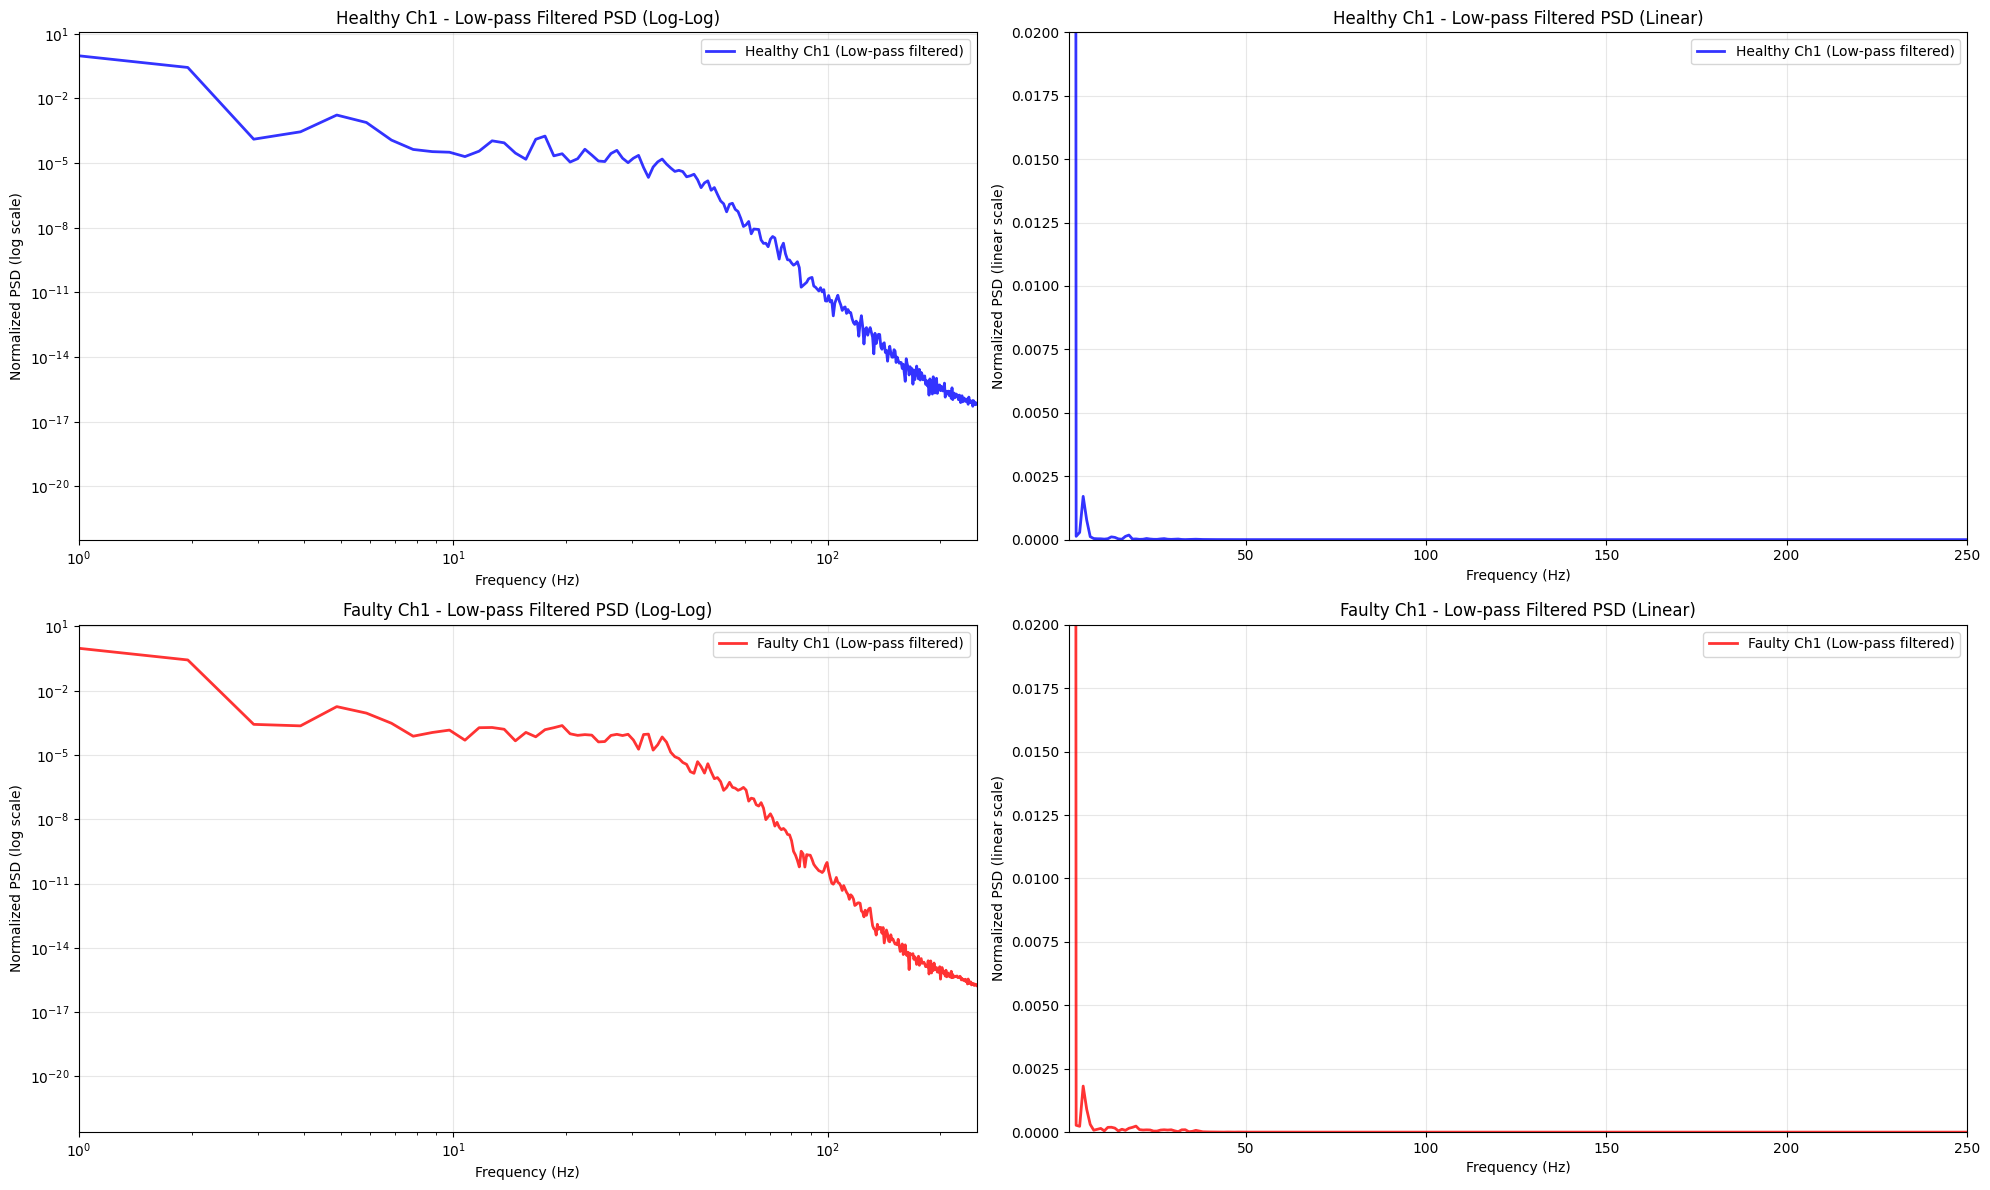

In [26]:
# Comparison plot: Hilbert envelope vs Original signal PSDs
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
top_y_lpf = 0.02
# Top row: Healthy signals comparison
# Left: Low-pass filtered PSD (log-log scale)
axes[0, 0].loglog(freqs_h_ch1_lpf, psd_h_ch1_lpf, 'b-', alpha=0.8, label='Healthy Ch1 (Low-pass filtered)', linewidth=2)
axes[0, 0].set_xlim(1, xlim)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Normalized PSD (log scale)')
axes[0, 0].set_title('Healthy Ch1 - Low-pass Filtered PSD (Log-Log)')
axes[0, 0].legend()

# Right: Low-pass filtered PSD (linear scale)
axes[0, 1].plot(freqs_h_ch1_lpf, psd_h_ch1_lpf, 'b-', alpha=0.8, label='Healthy Ch1 (Low-pass filtered)', linewidth=2)
axes[0, 1].set_xlim(1, xlim)
axes[0, 1].set_ylim(bottom=0, top=top_y_lpf)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Normalized PSD (linear scale)')
axes[0, 1].set_title('Healthy Ch1 - Low-pass Filtered PSD (Linear)')
axes[0, 1].legend()

# Bottom row: Faulty signals comparison
# Left: Low-pass filtered PSD (log-log scale)
axes[1, 0].loglog(freqs_f_ch1_lpf, psd_f_ch1_lpf, 'r-', alpha=0.8, label='Faulty Ch1 (Low-pass filtered)', linewidth=2)
axes[1, 0].set_xlim(1, xlim)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Normalized PSD (log scale)')
axes[1, 0].set_title('Faulty Ch1 - Low-pass Filtered PSD (Log-Log)')
axes[1, 0].legend()

# Right: Low-pass filtered PSD (linear scale)
axes[1, 1].plot(freqs_f_ch1_lpf, psd_f_ch1_lpf, 'r-', alpha=0.8, label='Faulty Ch1 (Low-pass filtered)', linewidth=2)
axes[1, 1].set_xlim(1, xlim)
axes[1, 1].set_ylim(bottom=0, top=top_y_lpf)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Normalized PSD (linear scale)')
axes[1, 1].set_title('Faulty Ch1 - Low-pass Filtered PSD (Linear)')
axes[1, 1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

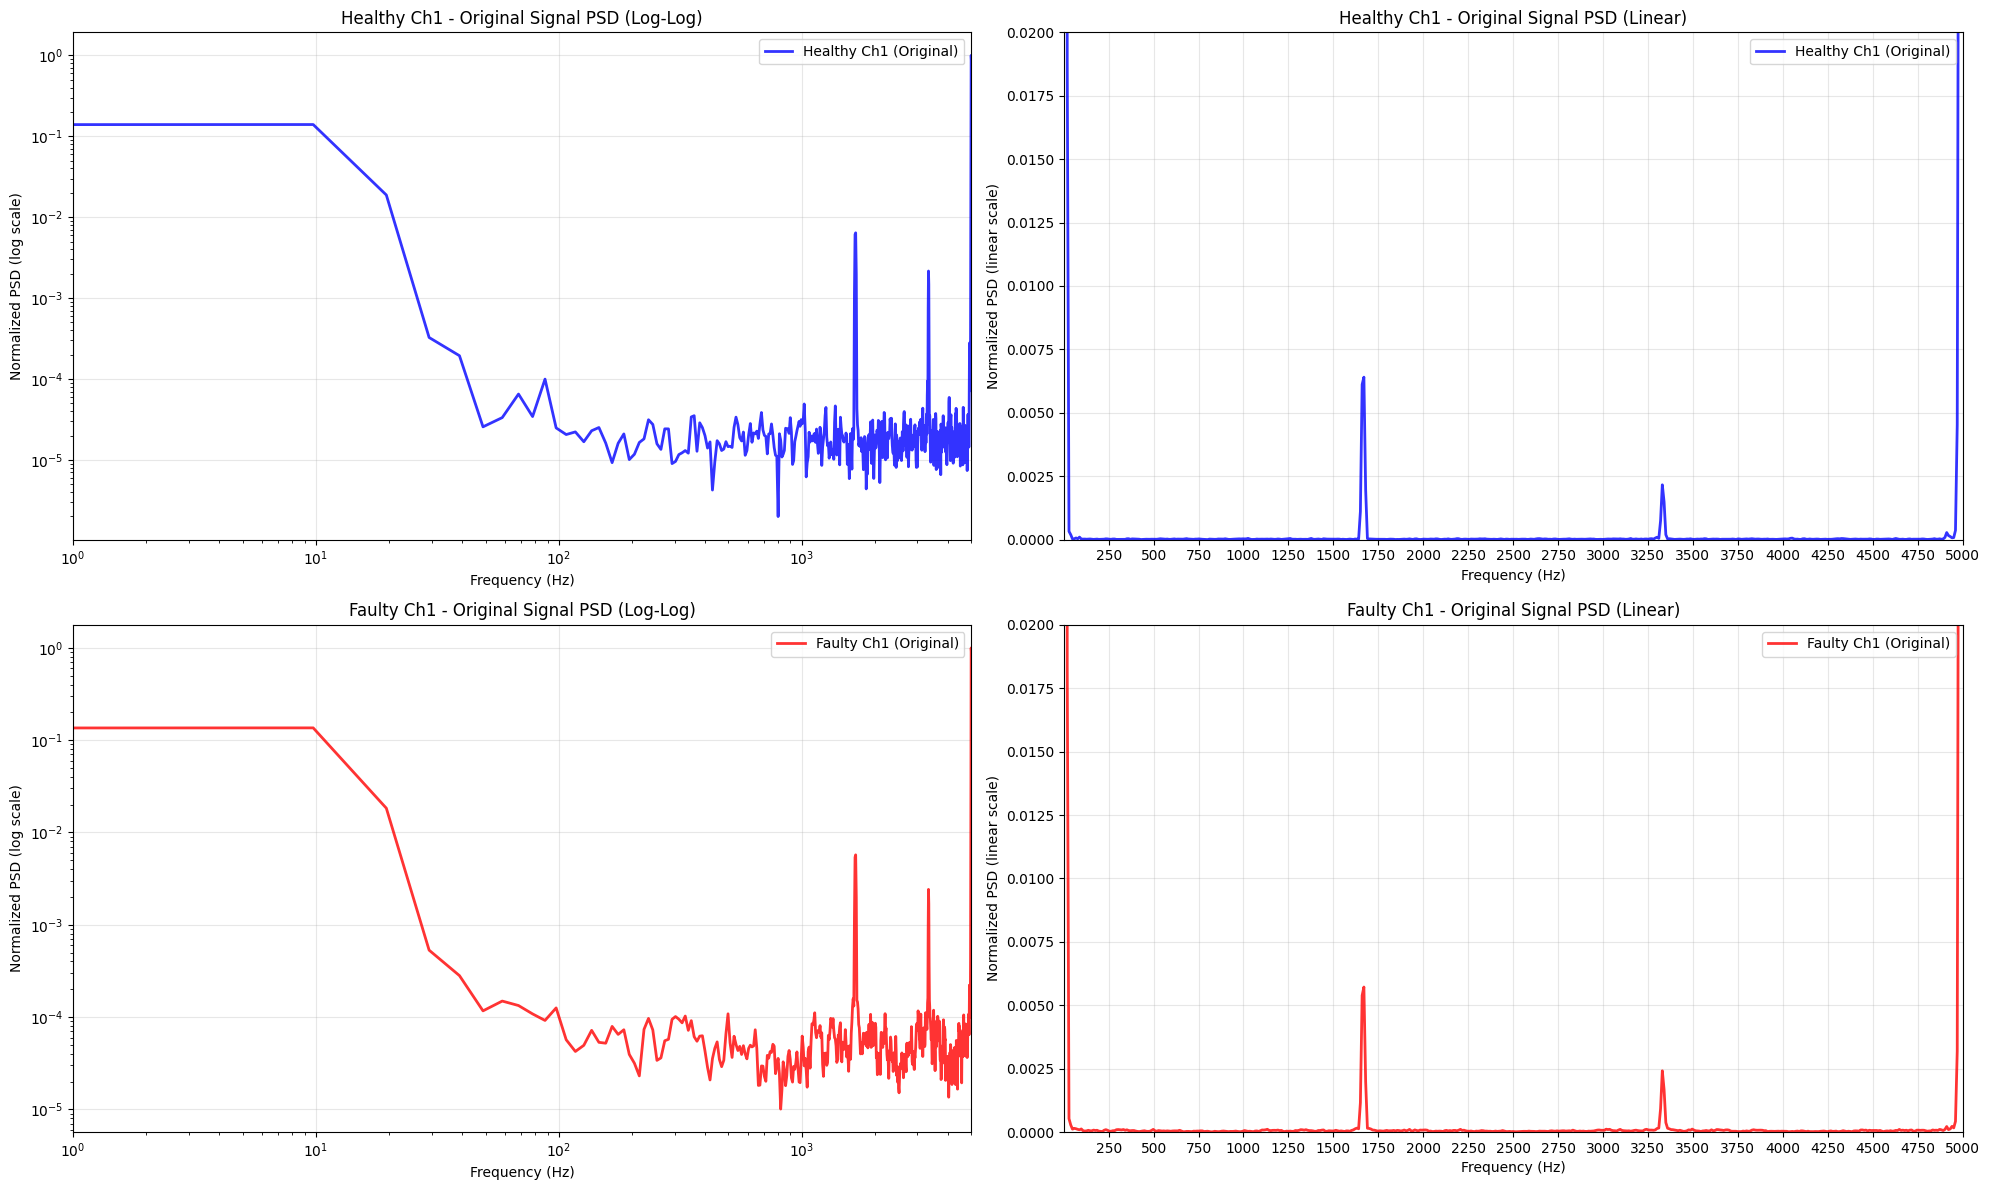

In [27]:
# Plot original signals PSDs - both log-log and linear scales
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Top row: Healthy original signal comparison
# Left: Original signal PSD (log-log scale)
axes[0, 0].loglog(freqs_h_ch1_orig, psd_h_ch1_orig, 'b-', alpha=0.8, label='Healthy Ch1 (Original)', linewidth=2)
axes[0, 0].set_xlim(1, nyquist)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Normalized PSD (log scale)')
axes[0, 0].set_title('Healthy Ch1 - Original Signal PSD (Log-Log)')
axes[0, 0].legend()

# Right: Original signal PSD (linear scale)
axes[0, 1].plot(freqs_h_ch1_orig, psd_h_ch1_orig, 'b-', alpha=0.8, label='Healthy Ch1 (Original)', linewidth=2)
axes[0, 1].set_xlim(1, nyquist)
axes[0, 1].set_ylim(bottom=0, top=top_y_lpf)
axes[0, 1].set_xticks(np.arange(250, nyquist+1, 250))
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Normalized PSD (linear scale)')
axes[0, 1].set_title('Healthy Ch1 - Original Signal PSD (Linear)')
axes[0, 1].legend()

# Bottom row: Faulty original signal comparison
# Left: Original signal PSD (log-log scale)
axes[1, 0].loglog(freqs_f_ch1_orig, psd_f_ch1_orig, 'r-', alpha=0.8, label='Faulty Ch1 (Original)', linewidth=2)
axes[1, 0].set_xlim(1, nyquist)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Normalized PSD (log scale)')
axes[1, 0].set_title('Faulty Ch1 - Original Signal PSD (Log-Log)')
axes[1, 0].legend()

# Right: Original signal PSD (linear scale)
axes[1, 1].plot(freqs_f_ch1_orig, psd_f_ch1_orig, 'r-', alpha=0.8, label='Faulty Ch1 (Original)', linewidth=2)
axes[1, 1].set_xlim(1, nyquist)
axes[1, 1].set_ylim(bottom=0, top=top_y_lpf)
axes[1, 1].set_xticks(np.arange(250, nyquist+1, 250))
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Normalized PSD (linear scale)')
axes[1, 1].set_title('Faulty Ch1 - Original Signal PSD (Linear)')
axes[1, 1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()
